# Demonstration of basic BSREM implementation with SIRF

This notebook is largely based on the `display_and_projection` notebook from the SIRF-Exercises to simulate some data.
Then it proceeds with reconstructing it with BSREM.

Author: Kris Thielemans  

CCP SyneRBI Synergistic Image Reconstruction Framework (SIRF).  
Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.  
Copyright 2015 - 2018, 2021, 2024 University College London.

This is software developed for the Collaborative Computational
Project in Synergistic Reconstruction for Biomedical Imaging
(http://www.ccpsynerbi.ac.uk/).

SPDX-License-Identifier: Apache-2.0

In [1]:
#%% make sure figures appears inline and animations works
# %matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#%% Initial imports etc
import numpy
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR
from sirf.Utilities import examples_data_path
#from sirf_exercises import exercises_data_path

from cil.utilities.display import show2D

Import functionality from the Python files in SIRF-Contribs.
(Note that in most set-ups, this will be from the installed files.)

In [4]:
from sirf.contrib.partitioner import partitioner
from sirf.contrib.BSREM.BSREM import BSREM1
from sirf.contrib.BSREM.BSREM import BSREM2

In [5]:
# Needed for get_subsets()
STIR.AcquisitionData.set_storage_scheme('memory')

In [6]:
# set-up redirection of STIR messages to files
_ = STIR.MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')

In [7]:
# fewer message from STIR and SIRF
STIR.set_verbosity(0)

In [8]:
#%% some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

FOV_filter=STIR.TruncateToCylinderProcessor()

## Try it with the thorax_single_slice data

In [9]:
# define the directory with input files for this notebook
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')

In [10]:
#%% Read in images
image = STIR.ImageData(os.path.join(data_path, 'emission.hv'))*0.05
attn_image = STIR.ImageData(os.path.join(data_path, 'attenuation.hv'))
template = STIR.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))

In [11]:
#%% save max for future displays
cmax = image.max()*.6

In [12]:
# create attenuation
acq_model_for_attn = STIR.AcquisitionModelUsingRayTracingMatrix()
asm_attn = STIR.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
asm_attn = STIR.AcquisitionSensitivityModel(attn_factors)
# set it up
asm_attn.set_up(template)
# use "standard" terminology for multiplicative factor (Note: there is no norm here)
mult_factors = attn_factors
# fake background (randoms+scatter)
background = template.get_uniform_copy(1)
# find additive_term for the acq_model
additive_term = background.clone()
asm_attn.normalise(additive_term)

# create acquisition model
acq_model = STIR.AcquisitionModelUsingRayTracingMatrix()
# we will increase the number of rays used for every Line-of-Response (LOR) as an example
# (it is not required for the exercise of course)
acq_model.set_num_tangential_LORs(5)
acq_model.set_acquisition_sensitivity(asm_attn)
acq_model.set_additive_term(additive_term)
# set-up
acq_model.set_up(template,image)

#%% simulate some data using forward projection
acquired_data=acq_model.forward(image)

print(acquired_data.max())

9.694265


In [13]:
initial_image=image.get_uniform_copy(cmax / 4)
FOV_filter.apply(initial_image)
# display
im_slice = initial_image.dimensions()[0] // 2

In [14]:
def initial_OSEM(acquired_data, additive_term, mult_factors, initial_image):
    num_subsets = 1
    data,acq_models, obj_funs = partitioner.data_partition(acquired_data, additive_term, mult_factors, num_subsets)

    obj_fun = STIR.make_Poisson_loglikelihood(data[0])
    obj_fun.set_acquisition_model(acq_models[0])
    recon = STIR.OSMAPOSLReconstructor()
    recon.set_objective_function(obj_fun)
    recon.set_current_estimate(initial_image)
    # some arbitrary numbers here
    recon.set_num_subsets(2)
    num_subiters = 14
    recon.set_num_subiterations(num_subiters)
    recon.set_up(initial_image)
    recon.process()
    return recon.get_output()

In [15]:
 OSEM_image = initial_OSEM(acquired_data, additive_term, mult_factors, initial_image)

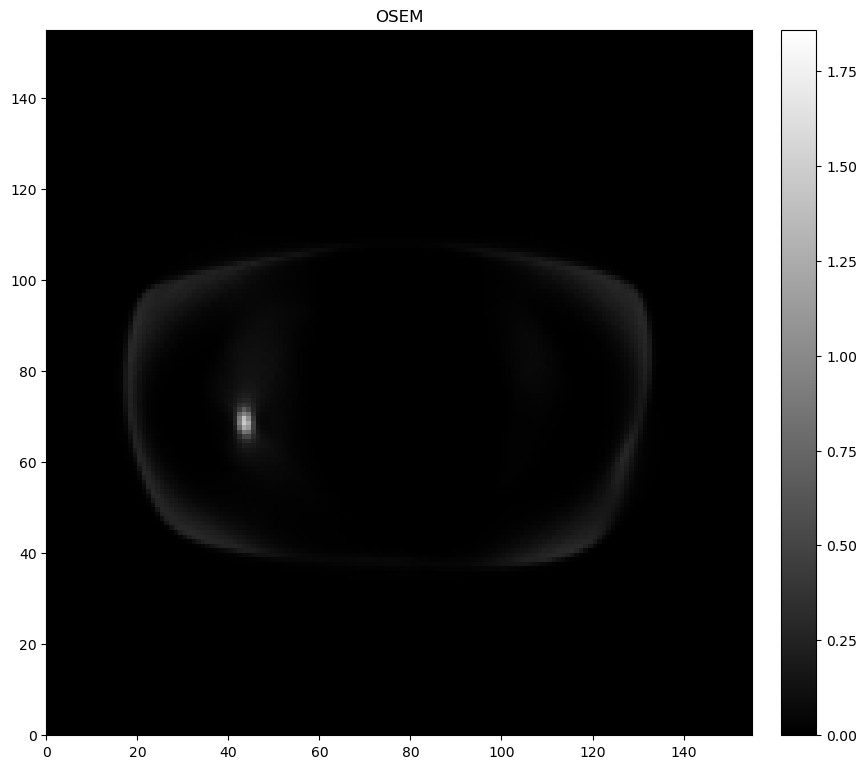

In [16]:
# plt.figure()
# plot_2d_image([1,1,1], OSEM_image.as_array()[im_slice,:,:], 'OSEM',[0,cmax])
show2D(OSEM_image.as_array()[im_slice,:,:], title='OSEM',fix_range=(0,cmax))

### partition data and construct prior

In [17]:
num_subsets = 7
data,acq_models, obj_funs = partitioner.data_partition(acquired_data,additive_term,mult_factors, num_subsets)

In [18]:
def add_RDP(beta, epsilon, obj_funs):
    '''
    construct RDP prior and add it evenly to every objective function.
    
    WARNING: return prior with beta/num_subsets (as currently needed for BSREM implementations)
    '''
    prior = STIR.RelativeDifferencePrior()
    # need to make it differentiable
    prior.set_epsilon(epsilon)
    # evenly distribute prior over subsets
    prior.set_penalisation_factor(beta / len(obj_funs));
    prior.set_up(initial_image)
    for f in obj_funs:
        f.set_prior(prior)
    return prior

In [19]:
prior = add_RDP(1, initial_image.max()*1e-4, obj_funs)

### compare 2 BSREM implementations

Note: intentionally setting update_objective_intervals to be not a multiple of num_subsets such that we can see the oscillations

In [20]:
bsrem1 = BSREM1(data, obj_funs, initial=OSEM_image, initial_step_size=1, relaxation_eta=.05, update_objective_interval=5)
bsrem1.max_iteration=300
bsrem1.run()

/tmp/ipykernel_114477/2861936778.py:3: DeprecationWarning: `run()` missing `iterations`
  bsrem1.run()


  0%|          | 0/300 [00:00<?, ?it/s]

In [21]:
bsrem2=BSREM2(data, acq_models, prior, initial=OSEM_image, initial_step_size=1, relaxation_eta=.05, update_objective_interval=5)
bsrem2.max_iteration = bsrem1.max_iteration
bsrem2.run()

/tmp/ipykernel_114477/2294716043.py:3: DeprecationWarning: `run()` missing `iterations`
  bsrem2.run()


  0%|          | 0/300 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

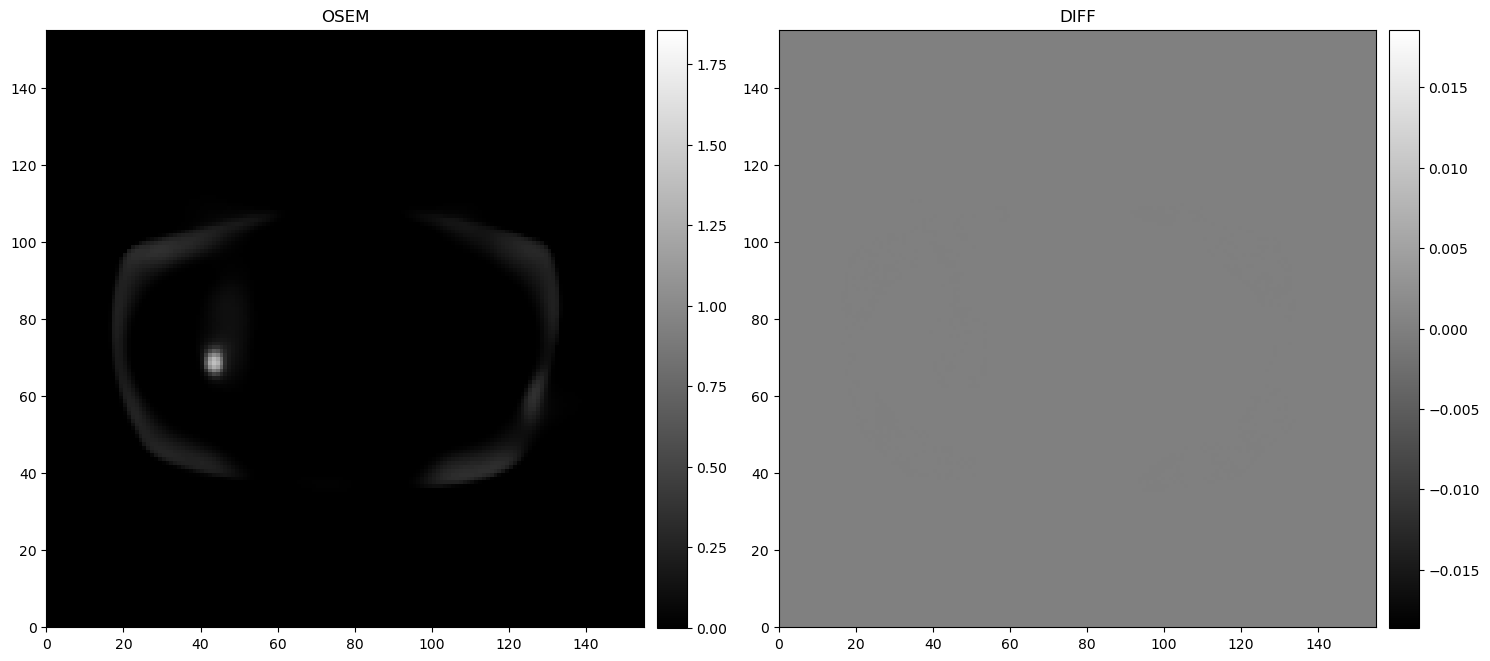

In [23]:
plt.figure()
tmp1=bsrem1.x
tmp2=bsrem2.x
# plot_2d_image([1,2,1], tmp1.as_array()[im_slice,:,:], 'BSREM1 result',[0, cmax])
# plot_2d_image([1,2,2], (tmp1-tmp2).as_array()[im_slice,:,:], 'diff',[-cmax/100, cmax/100])
show2D([ tmp1.as_array()[im_slice,:,:], (tmp1-tmp2).as_array()[im_slice,:,:]], 
       title=['OSEM', 'DIFF'],fix_range=[(0,cmax), (-cmax/100, cmax/100)])

Plot objective function for both implementations. If all well, you should see only 1 curve

AttributeError: 'tuple' object has no attribute 'shape'

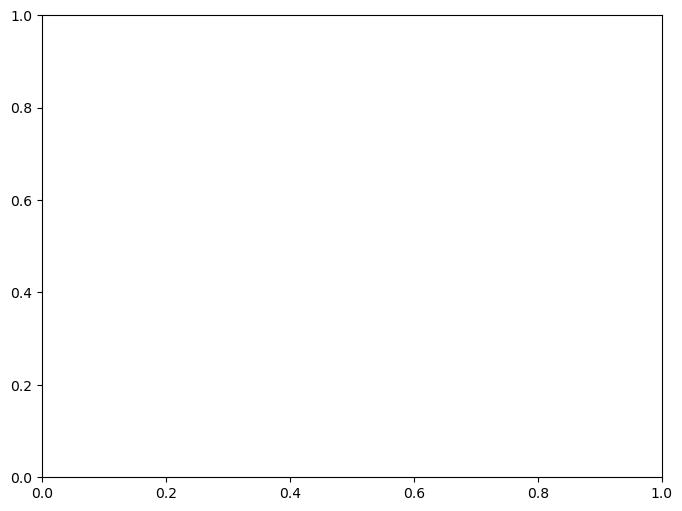

In [24]:
from cil.utilities.display import show1D

show1D([(bsrem1.iterations, bsrem1.loss), (bsrem2.iterations, bsrem2.loss)], title=['BSREM1', 'BSREM2'])
# plt.figure()
# plt.plot(bsrem1.iterations, bsrem1.loss)
# plt.plot(bsrem2.iterations, bsrem2.loss);


In [ ]:
plt.close('all')

## Now use the NEMA IQ data acquired on the mMR

The following names assume the data for the acquisition model has been written already by a preprocessing script. You might need to adjust this to your location and set-up.

In [25]:
os.chdir('/home/jovyan/work/Challenge24/data')

In [26]:
acquired_data = STIR.AcquisitionData('prompts.hs')
# background = STIR.AcquisitionData('background.hs')
background = STIR.AcquisitionData('additive.hs')
# mult_factors = STIR.AcquisitionData('mult_factors.hs')
mult_factors = STIR.AcquisitionData('multfactors.hs')

# somewhat crazy initialisation, currently hand-tuned scale
initial_image = STIR.ImageData('20170809_NEMA_MUMAP_UCL.hv')+.5

In [27]:
# crop it a bit to avoid wasting time
initial_image=initial_image.zoom_image(zooms=(1,1,1), offsets_in_mm=(0,0,0), size=(-1,200,200))

In [28]:
# hand-tuned cmax (TODO fix)
cmax = .15
im_slice = 70

In [29]:
OSEM_image = initial_OSEM(acquired_data, additive_term, mult_factors, initial_image)

error: ??? "'\\nERROR: ProjDataInfoSubsetByView: views[64]=64 out of range (64).\\n' exception caught at line 1076 of /opt/SIRF-SuperBuild/sources/SIRF/src/xSTIR/cSTIR/cstir.cpp; the reconstruction engine output may provide more information"

In [ ]:
plt.figure()
plot_2d_image([1,2,1], OSEM_image.as_array()[:,:,OSEM_image.dimensions()[1]//2 - 5], 'OSEM sagittal',[0,cmax])
plot_2d_image([1,2,2], OSEM_image.as_array()[im_slice,:,:], 'OSEM transverse',[0,cmax])

In [ ]:
# need to truncate max because of spurious high values at the edge of FOV
# TODO fix
OSEM_image = OSEM_image.minimum(.3)

In [ ]:
num_subsets = 7
data,acq_models, obj_funs = partitioner.data_partition(acquired_data, additive_term, mult_factors, num_subsets)

In [ ]:
prior = add_RDP(5, initial_image.max()*1e-4, obj_funs)

In [ ]:
bsrem1 = BSREM1(data, obj_funs, initial=OSEM_image, initial_step_size=1, relaxation_eta=.05, update_objective_interval=10)
bsrem1.max_iteration=80
bsrem1.run()

In [ ]:
plt.figure()
plot_2d_image([1,2,1], OSEM_image.as_array()[im_slice,:,:], 'initial OSEM',[0, cmax])
plot_2d_image([1,2,2], bsrem1.x.as_array()[im_slice,:,:], 'BSREM',[0, cmax])

In [ ]:
plt.figure()
plt.plot(bsrem1.iterations, bsrem1.loss);

In [ ]:
plt.close('all')